In [5]:
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt

In [6]:
nelx = 60
nely = 20
volfrac = 0.4
penal = 3.0
rmin = 1.5
ft = 1  # 0 = sensitivity filter, 1 = density filter

Minimum compliance problem with OC
ndes: 180 x 60
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based


/tmp/ipykernel_11682/988731375.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


it.: 1 , obj.: 2027.505 Vol.: 0.400, ch.: 0.200
it.: 2 , obj.: 1109.274 Vol.: 0.400, ch.: 0.200
it.: 3 , obj.: 759.678 Vol.: 0.400, ch.: 0.200
it.: 4 , obj.: 605.301 Vol.: 0.400, ch.: 0.200
it.: 5 , obj.: 551.514 Vol.: 0.400, ch.: 0.181
it.: 6 , obj.: 522.001 Vol.: 0.400, ch.: 0.200
it.: 7 , obj.: 503.316 Vol.: 0.400, ch.: 0.172
it.: 8 , obj.: 484.527 Vol.: 0.400, ch.: 0.200
it.: 9 , obj.: 466.601 Vol.: 0.400, ch.: 0.169
it.: 10 , obj.: 448.517 Vol.: 0.400, ch.: 0.193
it.: 11 , obj.: 431.318 Vol.: 0.400, ch.: 0.173
it.: 12 , obj.: 412.796 Vol.: 0.400, ch.: 0.200
it.: 13 , obj.: 393.572 Vol.: 0.400, ch.: 0.200
it.: 14 , obj.: 375.140 Vol.: 0.400, ch.: 0.200
it.: 15 , obj.: 358.937 Vol.: 0.400, ch.: 0.200
it.: 16 , obj.: 345.102 Vol.: 0.400, ch.: 0.200
it.: 17 , obj.: 334.371 Vol.: 0.400, ch.: 0.200
it.: 18 , obj.: 326.465 Vol.: 0.400, ch.: 0.200
it.: 19 , obj.: 320.638 Vol.: 0.400, ch.: 0.200
it.: 20 , obj.: 316.467 Vol.: 0.400, ch.: 0.200
it.: 21 , obj.: 313.684 Vol.: 0.400, ch.: 0.198

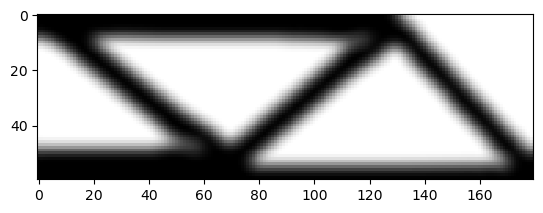

NameError: name 'raw_input' is not defined

In [ ]:
 
# MAIN DRIVER
def main(nelx,nely,volfrac,penal,rmin,ft):
	print("Minimum compliance problem with OC")
	print("ndes: " + str(nelx) + " x " + str(nely))
	print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
	print("Filter method: " + ["Sensitivity based","Density based"][ft])
	# Max and min stiffness
	Emin=1e-9
	Emax=1.0
	# dofs:
	ndof = 2*(nelx+1)*(nely+1)
	# Allocate design variables (as array), initialize and allocate sens.
	x=volfrac * np.ones(nely*nelx,dtype=float)
	xold=x.copy()
	xPhys=x.copy()
	g=0 # must be initialized to use the NGuyen/Paulino OC approach
	dc=np.zeros((nely,nelx), dtype=float)
	# FE: Build the index vectors for the for coo matrix format.
	KE=lk()
	edofMat=np.zeros((nelx*nely,8),dtype=int)
	for elx in range(nelx):
		for ely in range(nely):
			el = ely+elx*nely
			n1=(nely+1)*elx+ely
			n2=(nely+1)*(elx+1)+ely
			edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])
	# Construct the index pointers for the coo format
	iK = np.kron(edofMat,np.ones((8,1))).flatten()
	jK = np.kron(edofMat,np.ones((1,8))).flatten()    
	# Filter: Build (and assemble) the index+data vectors for the coo matrix format
	nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
	iH = np.zeros(nfilter)
	jH = np.zeros(nfilter)
	sH = np.zeros(nfilter)
	cc=0
	for i in range(nelx):
		for j in range(nely):
			row=i*nely+j
			kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
			kk2=int(np.minimum(i+np.ceil(rmin),nelx))
			ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
			ll2=int(np.minimum(j+np.ceil(rmin),nely))
			for k in range(kk1,kk2):
				for l in range(ll1,ll2):
					col=k*nely+l
					fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
					iH[cc]=row
					jH[cc]=col
					sH[cc]=np.maximum(0.0,fac)
					cc=cc+1
	# Finalize assembly and convert to csc format
	H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
	Hs=H.sum(1)
	# BC's and support
	dofs=np.arange(2*(nelx+1)*(nely+1))
	fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
	free=np.setdiff1d(dofs,fixed)
	# Solution and RHS vectors
	f=np.zeros((ndof,1))
	u=np.zeros((ndof,1))
	# Set load
	f[1,0]=-1
	# Initialize plot and plot the initial design
	plt.ion() # Ensure that redrawing is possible
	fig,ax = plt.subplots()
	im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
	interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
	fig.show()
   	# Set loop counter and gradient vectors 
	loop=0
	change=1
	dv = np.ones(nely*nelx)
	dc = np.ones(nely*nelx)
	ce = np.ones(nely*nelx)
	while change>0.01 and loop<2000:
		loop=loop+1
		# Setup and solve FE problem
		sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
		K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
		# Remove constrained dofs from matrix
		K = K[free,:][:,free]
		# Solve system 
		u[free,0]=spsolve(K,f[free,0])    
		# Objective and sensitivity
		ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
		obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
		dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
		dv[:] = np.ones(nely*nelx)
		# Sensitivity filtering:
		if ft==0:
			dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)
		elif ft==1:
			dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
			dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]
		# Optimality criteria
		xold[:]=x
		(x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)
		# Filter design variables
		if ft==0:   xPhys[:]=x
		elif ft==1:	xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
		# Compute the change by the inf. norm
		change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)
		# Plot to screen
		im.set_array(-xPhys.reshape((nelx,nely)).T)
		fig.canvas.draw()
		# Write iteration history to screen (req. Python 2.6 or newer)
		print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
					loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))
	# Make sure the plot stays and that the shell remains	
	plt.show()
	
#element stiffness matrix
def lk():
	E=1
	nu=0.3
	k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
	KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
	[k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
	[k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
	[k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
	[k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
	[k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
	[k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
	[k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
	return (KE)
# Optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
	l1=0
	l2=1e9
	move=0.2
	# reshape to perform vector operations
	xnew=np.zeros(nelx*nely)
	while (l2-l1)/(l1+l2)>1e-3:
		lmid=0.5*(l2+l1)
		xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
		gt=g+np.sum((dv*(xnew-x)))
		if gt>0 :
			l1=lmid
		else:
			l2=lmid
	return (xnew,gt)
# The real main driver    
if __name__ == "__main__":
	# Default input parameters
	nelx=180
	nely=60
	volfrac=0.4
	rmin=5.4
	penal=3.0
	ft=1 # ft==0 -> sens, ft==1 -> dens

	main(nelx,nely,volfrac,penal,rmin,ft)
